In [2]:
# Check how variable the data is across standard deviation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
dfX = pd.read_csv('Data/x_df.csv')
dfEEEE = pd.read_csv('Data/carrier_history2_eeee.csv')
dfUEEE = pd.read_csv('Data/carrier_history2_ueee.csv')
# drop the first column
dfX = dfX.drop(dfX.columns[0], axis=1)
dfEEEE = dfEEEE.drop(dfEEEE.columns[0], axis=1)
dfUEEE = dfUEEE.drop(dfUEEE.columns[0], axis=1)

In [3]:
dfX

,tot_dmd,dmd_b,dmd_l,hi_b,hi_l,hi_both,hi_neither
0,31590.0,11505.0,20085.0,1,0,0,0
1,34262.0,12098.0,22164.0,1,1,1,0
2,30434.0,10583.0,19851.0,0,0,0,1
3,35230.0,12145.0,23085.0,1,1,1,0
4,30417.0,10637.0,19780.0,0,0,0,1
...,...,...,...,...,...,...,...
695,39832.0,13834.0,25998.0,1,1,1,0
696,34740.0,12004.0,22736.0,1,1,1,0
697,32488.0,11472.0,21016.0,1,1,1,0
698,35663.0,13253.0,22410.0,1,1,1,0


In [4]:
dfUEEE

,trial,sample,carrier,sold,sold_priceable,revenue
0,0,50,AL1,9144,5347,3146261.27
1,0,51,AL1,10003,6101,3440480.04
2,0,52,AL1,8965,5515,2979623.95
3,0,53,AL1,10275,6463,3490313.85
4,0,54,AL1,8295,5103,2815404.09
...,...,...,...,...,...,...
2795,1,395,AL4,7157,4322,2009150.97
2796,1,396,AL4,6697,4002,1895709.04
2797,1,397,AL4,6332,3925,1793842.77
2798,1,398,AL4,6755,4050,1967270.95


In [5]:
dfEEEE

,trial,sample,carrier,sold,sold_priceable,revenue
0,0,50,AL1,9373,5646,3101057.35
1,0,51,AL1,10179,6361,3313840.00
2,0,52,AL1,9250,5814,2969986.94
3,0,53,AL1,10159,6453,3264309.68
4,0,54,AL1,8682,5582,2823085.99
...,...,...,...,...,...,...
2795,1,395,AL4,7220,4431,2057126.61
2796,1,396,AL4,6674,4015,1911002.68
2797,1,397,AL4,6137,3726,1773659.23
2798,1,398,AL4,6752,4079,1996951.81


In [6]:
def difference(df1, df2, carrier):
    df1 = df1[df1['carrier'] == carrier]
    df2 = df2[df2['carrier'] == carrier]
    df = pd.DataFrame()
    df['carrier'] = df1['carrier']
    df['revenue UEEE'] = df1['revenue']
    df['revenue EEEE'] = df2['revenue']
    df['difference'] = df1['revenue'] - df2['revenue']
    avg = df2['revenue'].mean()
    df['percent'] = 100 * df['difference'] / avg
    return df

In [7]:
dfY = difference(dfUEEE, dfEEEE,'AL1')
dfX = dfX.reset_index(drop=True)
dfY = dfY.reset_index(drop=True)
# merge dfx and dfy
df = dfX.merge(dfY, left_index=True, right_index=True)


In [8]:
from math import ceil, floor, log10

def get_bins(data, num_bins=20):
    """The goal is to have 'nice' sized bins with a boundary at zero.  This will almost always give
       a few more bins than requested, but it makes the graphs look good :-) """
    min_x = data.min()
    max_x = data.max()
    width = (max_x - min_x) / num_bins
    mults = [0.00001, 0.00002, 0.00005, 0.0001]
    while True:
        if mults[0] < width < mults[-1]:
            break
        mults = [m*10 for m in mults]
    
    # Now get the bin sizes
    if mults[0] < width < mults[1]:
        m = mults[0]
    elif mults[1] < width < mults[2]:
        m = mults[1]
    elif mults[2] < width < mults[3]:
        m = mults[2]

    min_x2 = m * floor(min_x / m)
    max_x2 = m * ceil(max_x / m)
    range2 = max_x2 - min_x2
    num_bins2 = int(range2 / m)

    bins = np.linspace(min_x2, max_x2, num_bins2+1)
    return bins


def win_loss_histogram(data, carrier, num_bins=10):
    min_x = data.min()
    max_x = data.max()
    width = (max_x - min_x) / num_bins
    custom_bins = get_bins(data, num_bins)
    pos_data, neg_data = data[data >= 0], data[data < 0]

    total_count = len(data)
    green_percent = 100 * len(pos_data) / total_count
    red_percent = 100 * len(neg_data) / total_count
    print(green_percent, red_percent)
    plt.hist(pos_data, bins=custom_bins, color='green', edgecolor='black', label=f'Positive (UEEE > EEEE) - {green_percent:.2f}%')
    plt.hist(neg_data, bins=custom_bins, color='red', edgecolor='black', label=f'Negative (UEEE < EEEE) - {red_percent:.2f}%')
    
    # Calculate mean and standard deviation
    mean = data.mean()
    std_dev = data.std()

    # Plot vertical lines at mean, first standard deviation, and second standard deviation
    plt.axvline(x=mean, color='black', linestyle='--', label='Mean')
    plt.axvline(x=mean + std_dev, color='blue', linestyle='--', label='Mean ± 1 Std Dev')
    plt.axvline(x=mean - std_dev, color='blue', linestyle='--')
    plt.axvline(x=mean + 2 * std_dev, color='orange', linestyle='--', label='Mean ± 2 Std Dev')
    plt.axvline(x=mean - 2 * std_dev, color='orange', linestyle='--')

    # count the number of samples in each of the standard deviation ranges separately on either side of the mean - 0-1, 1-2
    count_0std = len(data[(data < mean - 2 * std_dev)])
    count_1std = len(data[(data >= mean - 2 * std_dev) & (data <= mean - std_dev)])
    count_2std = len(data[(data >= mean - std_dev) & (data <= mean)])
    count_3std = len(data[(data >= mean) & (data <= mean + std_dev)])
    count_4std = len(data[(data >= mean + std_dev) & (data <= mean + 2 * std_dev)])
    count_5std = len(data[(data > mean + 2 * std_dev)])
    
    print("Data less than -2 std dev: ", count_0std)
    print("Data between -2 and -1 std dev: ", count_1std)
    print("Data between -1 and mean: ", count_2std)
    print("Data between mean and +1 std dev: ", count_3std)
    print("Data between +1 and +2 std dev: ", count_4std) 
    print("Data greater than +2 std dev: ", count_5std) 

    plt.title(f' % Revenue Difference Histogram for {carrier}')
    plt.xlabel('Revenue % Difference')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


58.142857142857146 41.857142857142854
Data less than -2 std dev:  0
Data between -2 and -1 std dev:  104
Data between -1 and mean:  291
Data between mean and +1 std dev:  189
Data between +1 and +2 std dev:  95
Data greater than +2 std dev:  21


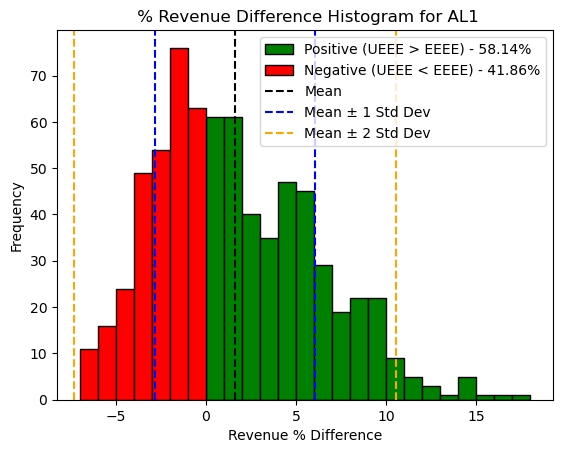

In [11]:
# revenue comparison for all the carriers
win_loss_histogram(df['percent'], 'AL1', num_bins=20)


In [49]:
df

,tot_dmd,dmd_b,dmd_l,hi_b,hi_l,hi_both,hi_neither,carrier,revenue UEEE,revenue EEEE,difference,percent
0,31590.0,11505.0,20085.0,1,0,0,0,AL1,3146261.27,3101057.35,45203.92,1.494635
1,34262.0,12098.0,22164.0,1,1,1,0,AL1,3440480.04,3313840.00,126640.04,4.187261
2,30434.0,10583.0,19851.0,0,0,0,1,AL1,2979623.95,2969986.94,9637.01,0.318641
3,35230.0,12145.0,23085.0,1,1,1,0,AL1,3490313.85,3264309.68,226004.17,7.472664
4,30417.0,10637.0,19780.0,0,0,0,1,AL1,2815404.09,2823085.99,-7681.90,-0.253996
...,...,...,...,...,...,...,...,...,...,...,...,...
695,39832.0,13834.0,25998.0,1,1,1,0,AL1,3987444.71,3535562.05,451882.66,14.941173
696,34740.0,12004.0,22736.0,1,1,1,0,AL1,3544031.23,3212539.01,331492.22,10.960550
697,32488.0,11472.0,21016.0,1,1,1,0,AL1,3190899.08,3043150.32,147748.76,4.885206
698,35663.0,13253.0,22410.0,1,1,1,0,AL1,3524370.12,3299888.18,224481.94,7.422333


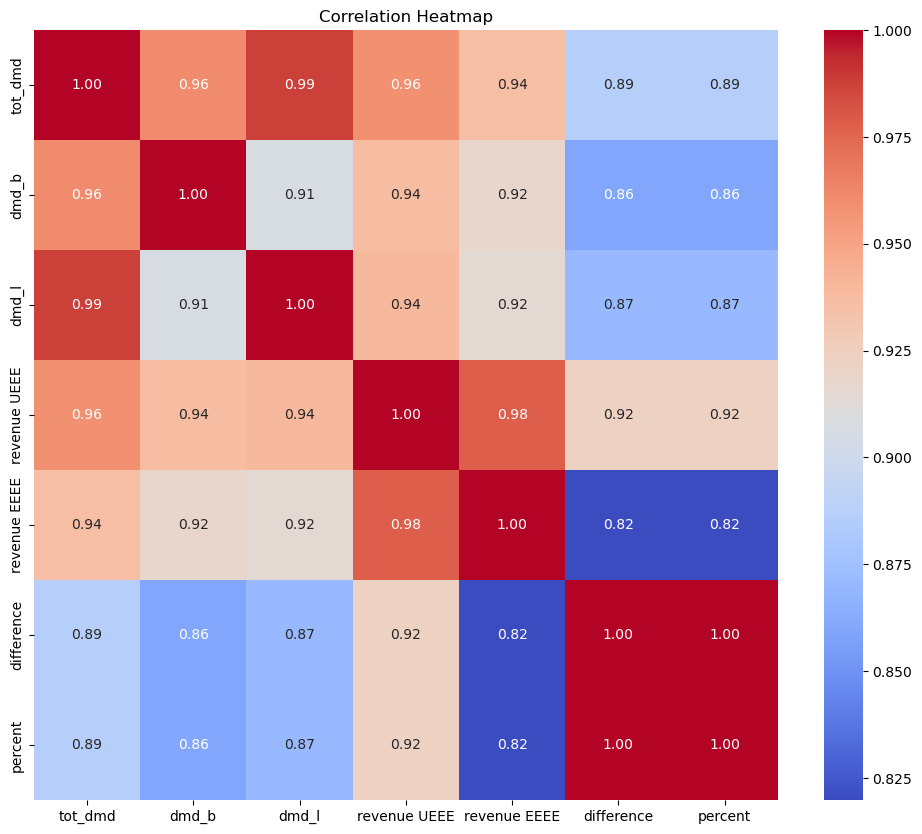

In [48]:
# we want to now understand the features that have the most impact on the revenue difference

dfhm = df.drop(columns=['carrier', 'hi_b', 'hi_l', 'hi_both', 'hi_neither'])
corr = dfhm.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()





In [15]:
# preparing the data for the model 
df['DiffSign'] = [1 if p > 0 else 0 for p in df1['difference']]


In [16]:

# create dfXt and dfYt for the model with specific columns
dfXt = dfX[['tot_dmd', 'dmd_b', 'dmd_l']]
dfYt = df['DiffSign']

# print and verify the data shapes
print(dfXt.shape)
print(dfYt.shape)

(700, 3)
(700,)


In [17]:
# Try XGBoost
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
x_train, x_test, y_train, y_test = train_test_split(dfXt, dfYt, test_size=0.25, random_state=42)
model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.86%


<Figure size 1200x800 with 0 Axes>

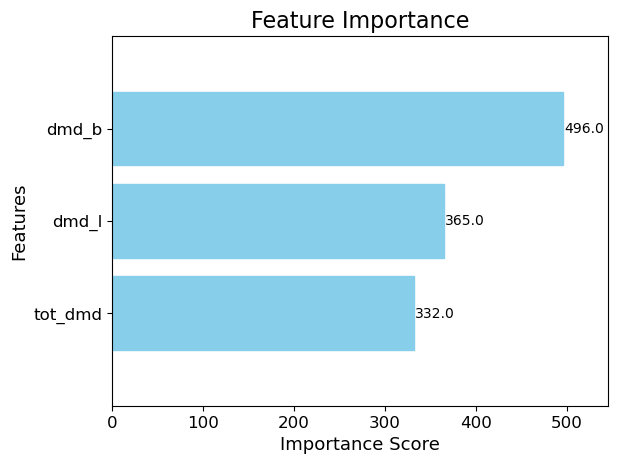

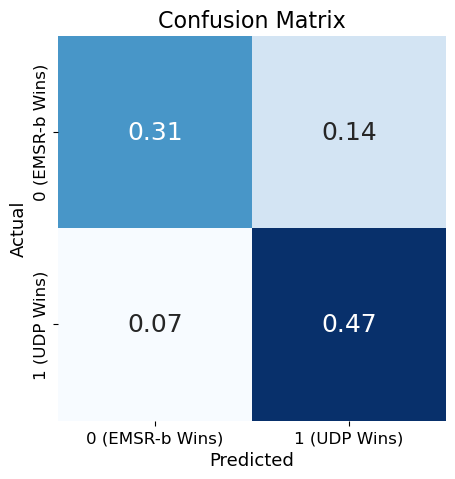

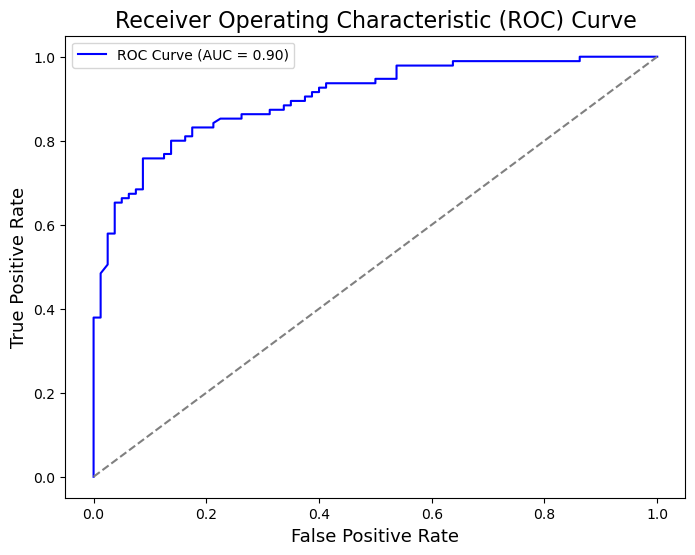

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from xgboost import plot_importance

# 1. Feature Importance Plot
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=10, importance_type='weight', height=0.8)  # Adjust the height for wider bars
plt.title('Feature Importance', fontsize=16)
plt.grid(False)  # Remove grid lines

# Customize the color and style
ax = plt.gca()
for bar in ax.patches:
    bar.set_color('skyblue')  
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Importance Score', fontsize=13)
plt.ylabel('Features', fontsize=13)

plt.show()

# 2. Confusion Matrix

# Predict and compute confusion matrix
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred, normalize="all")

# Plot confusion matrix
plt.figure(figsize=(5, 5))  # Adjust figure size for more room
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False,
            xticklabels=['0 (EMSR-b Wins)', '1 (UDP Wins)'],
            yticklabels=['0 (EMSR-b Wins)', '1 (UDP Wins)'],
            annot_kws={"size": 18})  # Font size for annotations
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 3. ROC Curve and AUC
y_proba = model.predict_proba(x_test)[:, 1]  # Probability for the positive class
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference line
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Receiver Operating Characteristic (ROC) Curve',fontsize=16)
plt.legend()
plt.show()

UEEE: Favored in business-heavy markets with volatile demand. 
Business passengers, characterized by lower price sensitivity and last-minute booking behavior, play a critical role in revenue optimization. The choice of strategy likely hinges on how well it captures and monetizes this segment.

EEEE: Performs better in leisure-heavy or mixed-demand markets where segmentation is well-defined.

In [44]:
# Try logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# create dfXt and dfYt for the model with specific columns
dfXt = dfX[['tot_dmd', 'dmd_b', 'dmd_l', 'hi_b', 'hi_l', 'hi_both', 'hi_neither']]
dfYt = df1['DiffSign']

x_train, x_test, y_train, y_test = train_test_split(dfXt, dfYt, test_size=0.25, random_state=42)


logreg = LogisticRegression(random_state=16, solver="liblinear")
logreg.fit(x_train, y_train.values.ravel())
y_pred = logreg.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8228571428571428


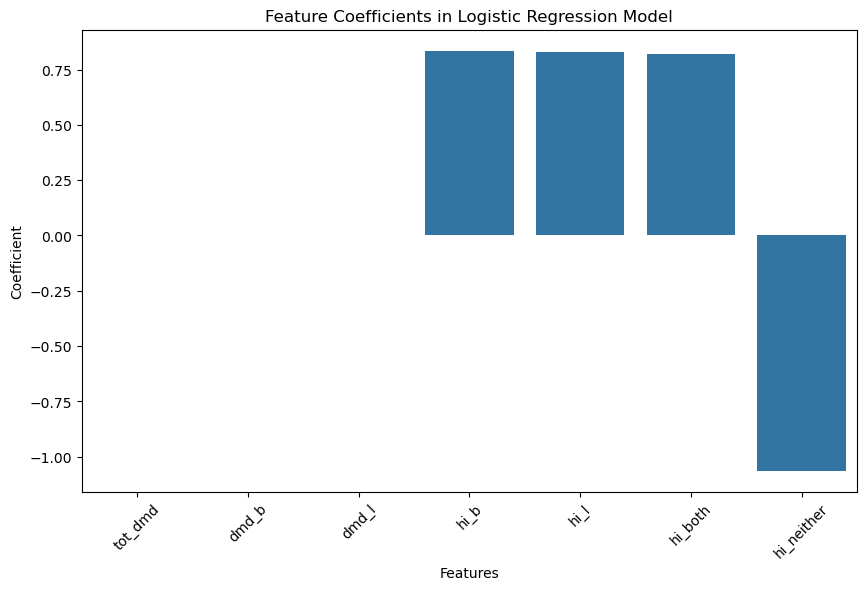

      Feature   Coefficient
0     tot_dmd -9.856944e-07
1       dmd_b -3.293935e-05
2       dmd_l  3.195367e-05
3        hi_b  8.347577e-01
4        hi_l  8.302232e-01
5     hi_both  8.203971e-01
6  hi_neither -1.063118e+00

Odds Ratios for each Feature:
       Feature  Odds Ratio
0     tot_dmd    0.999999
1       dmd_b    0.999967
2       dmd_l    1.000032
3        hi_b    2.304256
4        hi_l    2.293831
5     hi_both    2.271402
6  hi_neither    0.345377


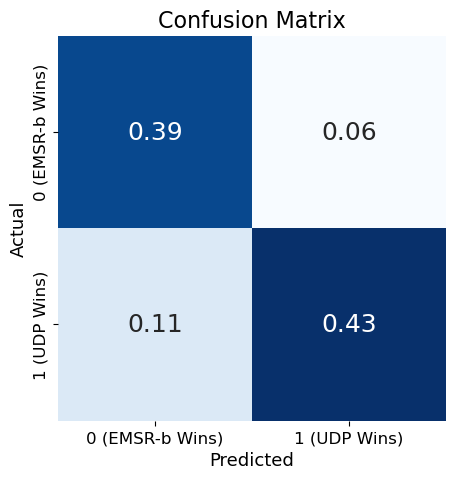

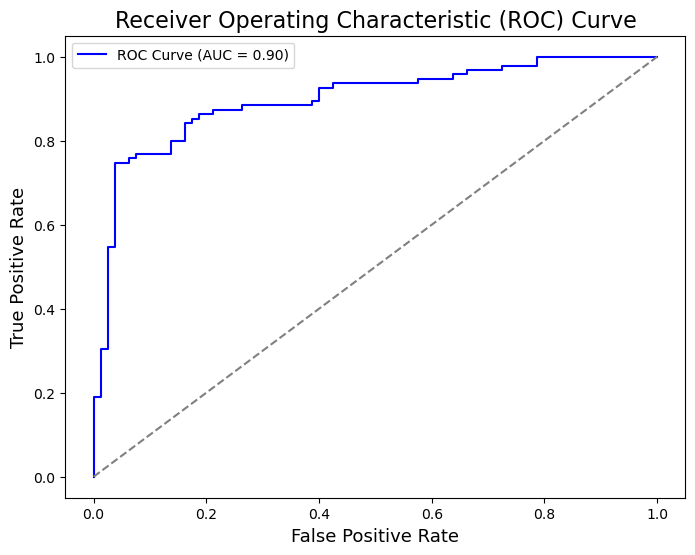

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Get coefficients and intercept
coefficients = logreg.coef_[0]
intercept = logreg.intercept_[0]
features = dfXt.columns

# 1. Coefficient Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Coefficients in Logistic Regression Model')
plt.xticks(rotation=45)
plt.show()

# Print coefficients with names for reference
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
print(coef_df)

# Interpretation (odds ratio)
odds_ratios = np.exp(coefficients)
odds_ratio_df = pd.DataFrame({'Feature': features, 'Odds Ratio': odds_ratios})
print("\nOdds Ratios for each Feature:\n", odds_ratio_df)

# 2. Confusion Matrix (as percentages)
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_, normalize="all")

# cm = confusion_matrix(y_test, y_pred, normalize="all")

# Plot confusion matrix
plt.figure(figsize=(5, 5))  # Adjust figure size for more room
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False,
            xticklabels=['0 (EMSR-b Wins)', '1 (UDP Wins)'],
            yticklabels=['0 (EMSR-b Wins)', '1 (UDP Wins)'],
            annot_kws={"size": 18})  # Font size for annotations
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# 3. ROC Curve and AUC
y_proba = logreg.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference line
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Receiver Operating Characteristic (ROC) Curve',fontsize=16)
plt.legend()
plt.show()

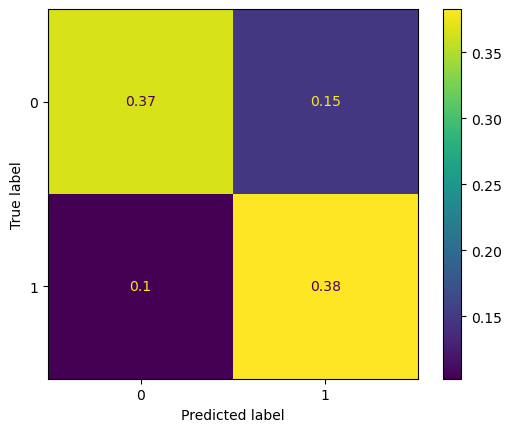

In [40]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=logreg.classes_, normalize="all")
# cnf_matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                                      display_labels=logreg.classes_)
disp.plot()
plt.show()

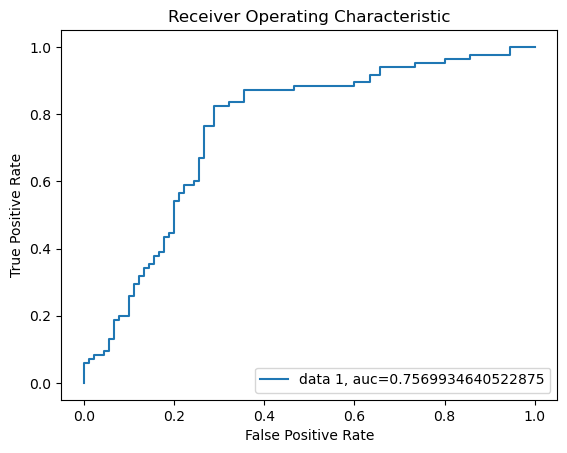

In [41]:
# Create a Receiver Operating Curve (ROC) with the Area Under the Curve (AUC)
y_pred_proba = logreg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
# also plot the axis labels
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()